# GVSA Age Group Overview

This notebook provides age group gross statistics and comparisons.

## Contents
- Analysis by age groups (U10, U11, U12, etc.)
- Age group comparisons
- Use gvsa.age_progression utilities


In [1]:
# Import required libraries
import sys
from pathlib import Path
import re

# Database and ORM
from pony.orm import db_session, select, count
from gvsa.models import db, Season, Division, Team, TeamSeason, Match, Club
from gvsa.db_pony import GVSA_Database
from gvsa.age_progression import extract_season_year, calculate_age_group

# Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")


Libraries imported successfully


## Connect to Database


In [8]:
# Connect to the database
db_path = Path("/projects/gvsa_scrape/gvsa/gvsa_data2.db")

# Explicitly bind the database (required for Jupyter notebooks)
try:
    if hasattr(db, 'provider') and db.provider:
        db.disconnect()
except Exception:
    pass

# Bind to the database
db.bind(provider='sqlite', filename=str(db_path), create_db=False)
db.generate_mapping(create_tables=False)

# Initialize database connection
gvsa_db = GVSA_Database(str(db_path))

print(f"Connected to database: {db_path}")
print(f"Database file exists: {db_path.exists()}")

# Verify connection
with db_session:
    season_count = count(s for s in Season)
    print(f"Seasons in database: {season_count}")


Connected to database: /projects/gvsa_scrape/gvsa/gvsa_data2.db
Database file exists: True
Seasons in database: 30


## Extract Age Groups from Divisions


In [ ]:
def extract_age_group_from_division(division_name: str) -> str:
    """Extract age group label from division name."""
    # Match patterns like U10, U11, U15/16, U17/19
    range_pattern = r'U(\d{1,2})/(\d{1,2})'
    match = re.search(range_pattern, division_name)
    if match:
        return f"U{match.group(1)}/{match.group(2)}"
    
    # Use negative lookahead to ensure not followed by another digit
    # This works with spaces, underscores, and other non-digit characters
    single_pattern = r'U(\d{1,2})(?!\d)'
    match = re.search(single_pattern, division_name)
    if match:
        return f"U{match.group(1)}"
    
    # If no age group found, return division name for visibility
    # This addresses cases like "SC Qualifier" where age group isn't in the name
    return f"Unknown: {division_name}"

# Load team season data with age groups
with db_session:
    age_group_data = []
    for ts in select(ts for ts in TeamSeason):
        age_group = extract_age_group_from_division(ts.division.division_name)
        age_group_data.append({
            'age_group': age_group,
            'division': ts.division.division_name,
            'season': ts.division.season.season_name,
            'wins': ts.wins,
            'losses': ts.losses,
            'ties': ts.ties,
            'points': ts.points,
            'goals_for': ts.goals_for,
            'goals_against': ts.goals_against,
            'goal_differential': ts.goal_differential,
        })
    
    df_age_groups = pd.DataFrame(age_group_data)

print(f"Loaded {len(df_age_groups)} team season records")
print(f"\nAge groups found: {sorted(df_age_groups['age_group'].unique())}")
df_age_groups.head(10)


Loaded 25798 team season records

Age groups found: ['U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U15/16', 'U16', 'U17', 'U17/18', 'U17/19', 'U18', 'U18/19', 'U19', 'U7', 'U8', 'U9', 'Unknown']


,age_group,division,season,wins,losses,ties,points,goals_for,goals_against,goal_differential
0,U10,U10 Boys 3rd Division,Fall 2014,8,0,0,24,35,5,24
1,U10,U10 Girls 2nd Division,Fall 2014,8,0,0,24,59,6,28
2,U17/19,U17/19 Girls Elite,Fall 2014,8,0,0,24,33,10,19
3,U15/16,U15/16 Girls 3rd Division,Fall 2014,4,0,4,16,17,8,9
4,U10,U10 Boys 3rd Division,Fall 2014,5,3,0,15,30,15,13
5,U13,U13 Girls 2nd Division,Fall 2014,7,0,1,22,36,7,22
6,U10,U10 Girls 2nd Division,Fall 2014,7,1,0,21,50,16,23
7,U10,U10 Girls 2nd Division,Fall 2014,4,3,1,13,29,20,8
8,U10,U10 Girls 2nd Division,Fall 2014,4,3,1,13,37,47,1
9,U17/19,U17/19 Girls Elite,Fall 2014,5,1,2,17,23,9,12


## Age Group Statistics


In [10]:
# Statistics by age group
age_group_stats = df_age_groups.groupby('age_group').agg({
    'points': ['count', 'mean', 'std', 'min', 'max'],
    'goals_for': 'mean',
    'goals_against': 'mean',
    'goal_differential': 'mean',
    'wins': 'mean',
    'losses': 'mean',
    'ties': 'mean'
}).round(2)

print("Age Group Statistics:")
print("=" * 80)
print(age_group_stats)

# Summary by age group
print("\nSummary by Age Group:")
print("=" * 80)
summary = df_age_groups.groupby('age_group').agg({
    'points': ['count', 'mean'],
}).round(2)
summary.columns = ['Team_Count', 'Avg_Points']
print(summary)


Age Group Statistics:
          points                      goals_for goals_against  \
           count   mean   std min max      mean          mean   
age_group                                                       
U10         1867  11.23  6.68  -1  24     23.34         23.36   
U11         2042  11.04  6.64  -1  24     20.12         20.21   
U12         2017  11.02  6.44  -2  24     19.13         19.23   
U13         1387  10.79  6.60  -2  24     15.89         15.99   
U14         1366  10.81  6.73  -1  24     16.30         16.34   
U15          694  10.37  7.26  -1  24     17.34         17.44   
U15/16       275  11.31  6.51  -1  24     17.36         17.35   
U16           91  11.12  6.23  -1  24     16.89         17.12   
U17          415   9.68  7.04  -2  24     15.87         16.19   
U17/18       122  11.29  6.84  -1  24     18.34         18.81   
U17/19       220  11.11  6.36   0  24     18.93         19.30   
U18           95  11.48  6.93  -3  24     21.81         20.94   
U18

## Age Group Visualizations


/tmp/ipykernel_82123/169759990.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df_age_groups[df_age_groups['age_group'] == ag]['points'].values for ag in age_groups_sorted],


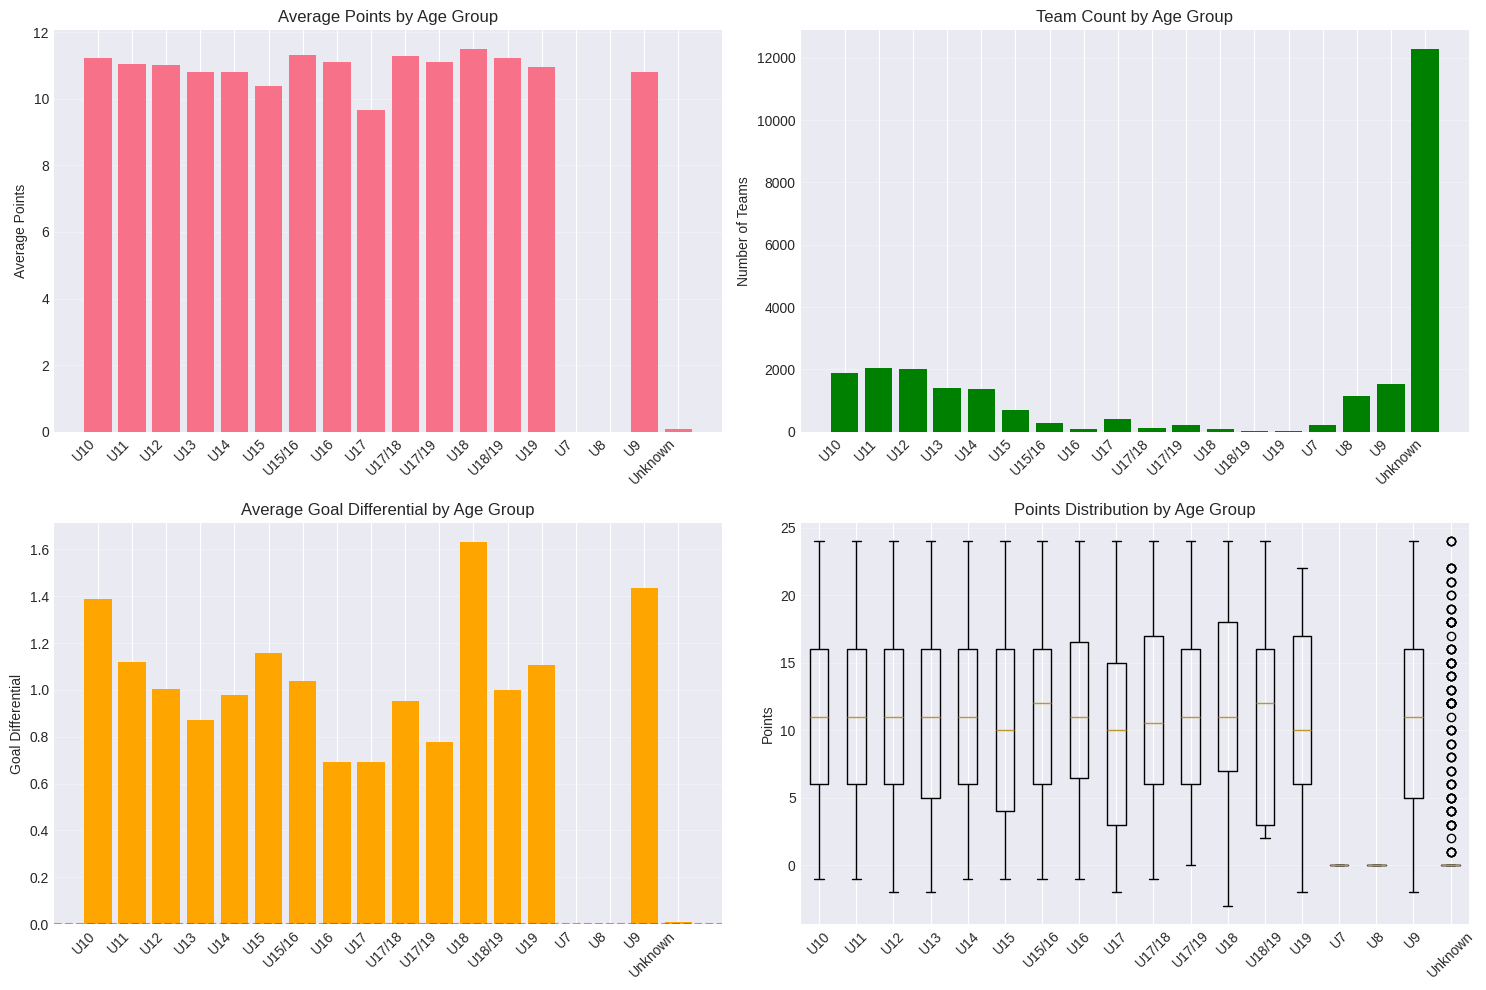

In [11]:
# Visualize age group comparisons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average points by age group
age_avg_points = df_age_groups.groupby('age_group')['points'].mean().sort_index()
axes[0, 0].bar(range(len(age_avg_points)), age_avg_points.values)
axes[0, 0].set_xticks(range(len(age_avg_points)))
axes[0, 0].set_xticklabels(age_avg_points.index, rotation=45, ha='right')
axes[0, 0].set_title('Average Points by Age Group')
axes[0, 0].set_ylabel('Average Points')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Team count by age group
age_counts = df_age_groups.groupby('age_group').size().sort_index()
axes[0, 1].bar(range(len(age_counts)), age_counts.values, color='green')
axes[0, 1].set_xticks(range(len(age_counts)))
axes[0, 1].set_xticklabels(age_counts.index, rotation=45, ha='right')
axes[0, 1].set_title('Team Count by Age Group')
axes[0, 1].set_ylabel('Number of Teams')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Average goal differential by age group
age_avg_gd = df_age_groups.groupby('age_group')['goal_differential'].mean().sort_index()
axes[1, 0].bar(range(len(age_avg_gd)), age_avg_gd.values, color='orange')
axes[1, 0].set_xticks(range(len(age_avg_gd)))
axes[1, 0].set_xticklabels(age_avg_gd.index, rotation=45, ha='right')
axes[1, 0].set_title('Average Goal Differential by Age Group')
axes[1, 0].set_ylabel('Goal Differential')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Box plot of points distribution by age group
age_groups_sorted = sorted(df_age_groups['age_group'].unique())
df_age_groups['age_group_ordered'] = pd.Categorical(df_age_groups['age_group'], categories=age_groups_sorted, ordered=True)
axes[1, 1].boxplot([df_age_groups[df_age_groups['age_group'] == ag]['points'].values for ag in age_groups_sorted], 
                   labels=age_groups_sorted)
axes[1, 1].set_title('Points Distribution by Age Group')
axes[1, 1].set_ylabel('Points')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
